# Introduction - Using COSINE Metric

In this notebook we demonstrate the use of **LSI (Latent Semantic Indexing)** technique of Information Retrieval context to make trace link recovery between Features and Bug Reports.

We model our study as follows:

* Each bug report title, summary and description compose a single query.
* We use each feature description and title as an entire document that must be returned to the query made

This notebook follows the analysis made in **oracle_v2_analysis**, where we obtained a Cohen's kappa score of _0.41_ between the answers of the researcher and the answers of the volunteers.

# Import Libraries

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import pprint

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm

from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore')

# Load Datasets

In [2]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()
br_2_features_matrix_final = fd.Feat_BR_Oracles.read_br_2_features_matrix_final_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (21, 8)
BR_2_Features Matrix Final.shape: (91, 4)


# Running LSI Model - Exp-Vol UNION Oracle

In [3]:
models_runner_1 = Feat_BR_Models_Runner()

lsi_model_1 = models_runner_1.run_lsi_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)

sim_thresh = 0.0

lsi_eval_t1 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=1, sim_threshold=sim_thresh)
lsi_eval_t3 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=3, sim_threshold=sim_thresh)
lsi_eval_t5 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=5, sim_threshold=sim_thresh)
lsi_eval_t10 = evaluator_1.evaluate_model(model=lsi_model_1, top_value=10, sim_threshold=sim_thresh)

Features.shape: (21, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Expert and Volunteers Matrix UNION.shape: (91, 21)


# Similarity Matrix

In [4]:
aux_functions.highlight_df(lsi_model_1.get_sim_matrix().iloc[0:23, 0:14])

Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
feat_name,,,,,,,,,,,,,,
new_awesome_bar,0.320741,0.568394,0.671144,0.931044,0.164355,0.631198,0.181918,0.640709,0.164355,0.29042,0.419515,0.624393,0.586379,0.153829
windows_child_mode,0.0561108,0.406251,0.165129,0.0772069,0.212747,0.206565,0.126042,0.223301,0.212747,0.0972844,0.335712,0.317819,0.216041,0.199122
apz_async_scrolling,0.00122383,0.0295661,0.047032,0.0630632,0.042386,0.260099,0.00498738,0.173511,0.042386,0.0193822,0.134189,0.0447946,0.0756162,0.0396715
browser_customization,0.0252172,0.279508,0.057479,0.139368,0.520398,0.0431226,0.102766,0.0478245,0.520398,0.237966,0.210116,0.0615864,0.233519,0.48707
pdf_viewer,0.00557269,0.048238,0.0127021,0.0170318,0.193004,0.00952956,0.0227099,0.0105686,0.193004,0.0882564,0.00697391,0.022841,0.131052,0.180644
context_menu,0.971288,0.429624,0.44198,0.131035,0.0496182,0.33884,0.0514961,0.430191,0.0496182,0.889817,0.326,0.351809,0.111389,0.0464405
w10_comp,0.190804,0.318948,0.220759,0.23969,0.433016,0.491275,0.179211,0.514725,0.433016,0.372015,0.785257,0.714008,0.468447,0.405285
tts_in_desktop,0.0175157,0.202421,0.0399245,0.0898432,0.400903,0.59806,0.0713803,0.528585,0.400903,0.183324,0.125994,0.0474448,0.260753,0.375228
tts_in_rm,0.0231009,0.256051,0.0526551,0.127672,0.476724,0.430549,0.0941412,0.433093,0.476724,0.217995,0.192482,0.218953,0.259802,0.446193


# Analysis of BR x Feat Generated Traces

In [5]:
def get_features(br_id, matrix):
    features_ids = ""
    matrix = matrix.T
      
    for col in matrix.columns:
        if matrix.at[br_id, col] == 1:
            if features_ids == "":
                features_ids = str(matrix.columns.get_loc(col) + 1)
            else:
                features_ids = features_ids + " " + str(matrix.columns.get_loc(col) + 1)
    
    return features_ids

In [6]:
cols = ['Features_IDs_lsi_t1_m','Features_IDs_lsi_t3_m','Features_IDs_lsi_t5_m','Features_IDs_lsi_t10_m','Features_IDs_orc']

br_2_features_matrix_final['Features_IDs_lsi_t1_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t1['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t3_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t3['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t5_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t5['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_lsi_t10_m'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], lsi_eval_t10['trace_links_df']), axis=1))
br_2_features_matrix_final['Features_IDs_orc'] = list(bugreports.apply(lambda row : get_features(row['Bug_Number'], evaluator_1.get_oracle_df()), axis=1))
br_2_features_matrix_final.replace(" ", "", inplace=True)

br_2_features_matrix_final['f_names_lsi_t1'] = br_2_features_matrix_final.Features_IDs_lsi_t1_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t3'] = br_2_features_matrix_final.Features_IDs_lsi_t3_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t5'] = br_2_features_matrix_final.Features_IDs_lsi_t5_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_lsi_t10'] = br_2_features_matrix_final.Features_IDs_lsi_t10_m.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['f_names_orc'] = br_2_features_matrix_final.Features_IDs_orc.apply(lambda row : [features[features.Feature_Number == int(f_id)].Feature_Shortname for f_id in row.split(" ") if f_id != ""])
br_2_features_matrix_final['bug_title'] = br_2_features_matrix_final.apply(lambda row : bugreports[bugreports.Bug_Number == int(row.name)].Summary.values[0], axis=1)

cols2 = ['f_names_orc','f_names_lsi_t1','f_names_lsi_t3','f_names_lsi_t5','f_names_lsi_t10']

br_2_features_matrix_final[cols2].head(10)

,f_names_orc,f_names_lsi_t1,f_names_lsi_t3,f_names_lsi_t5,f_names_lsi_t10
Bug_Number,,,,,
1248267,[[context_menu]],[[context_menu]],"[[new_awesome_bar], [context_menu], [w10_comp]]","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro..."
1248268,[[browser_customization]],[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [webgl2]]","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro..."
1257087,[],[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [pointer_l...","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro..."
1264988,[[new_awesome_bar]],[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [notificationb...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [..."
1267480,[],[[webgl2]],"[[browser_customization], [tts_in_rm], [webgl2]]","[[browser_customization], [w10_comp], [tts_in_...","[[windows_child_mode], [browser_customization]..."
1267501,[[apz_async_scrolling]],[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [tts_in_desktop]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [apz..."
1269348,[],[[indicator_device_perm]],"[[new_awesome_bar], [w10_comp], [indicator_dev...","[[new_awesome_bar], [w10_comp], [indicator_dev...","[[new_awesome_bar], [windows_child_mode], [bro..."
1269485,[[apz_async_scrolling]],[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [tts_in_desktop]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [apz..."
1270274,[],[[webgl2]],"[[browser_customization], [tts_in_rm], [webgl2]]","[[browser_customization], [w10_comp], [tts_in_...","[[windows_child_mode], [browser_customization]..."


# Analysis of Precision and Recall

Evaluating LSI Model ----- 


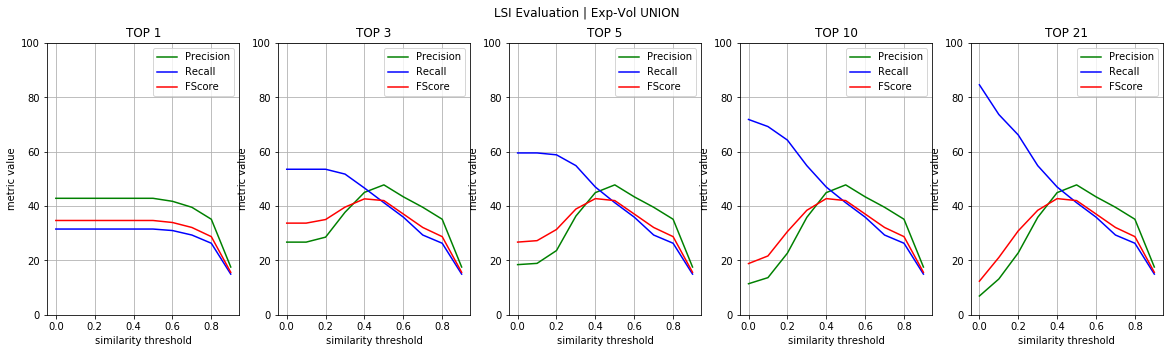

In [7]:
results = evaluator_1.run_evaluator(models=[lsi_model_1], top_values=[1,3,5,10,21], sim_thresholds=[(sm.SimilarityMeasure.COSINE, s_thresh/10) for s_thresh in range(0,10)])
evaluator_1.plot_evaluations_2(title='LSI Evaluation | Exp-Vol UNION', results=results)

# Analysis of False Positives

_Analysis of BR-Feat Traces with Low Precision_

In [8]:
from scipy.sparse import csr_matrix
from sklearn.metrics import precision_recall_fscore_support

models_runner_2 = Feat_BR_Models_Runner()
lsi_model_2 = models_runner_2.run_lsi_model()

evaluator_2 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)
results_2 = evaluator_2.evaluate_model(model=lsi_model_2, top_value=3, sim_threshold=0.0)

Features.shape: (21, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Expert and Volunteers Matrix UNION.shape: (91, 21)


In [9]:
display(aux_functions.highlight_df(lsi_model_2.get_sim_matrix().iloc[0:23, 0:14]))
display(aux_functions.highlight_df(evaluator_2.get_oracle_df().iloc[0:23, 0:14]))
display(aux_functions.highlight_df(results_2['trace_links_df'].iloc[0:23, 0:14]))

Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
feat_name,,,,,,,,,,,,,,
new_awesome_bar,0.320741,0.568394,0.671144,0.931044,0.164355,0.631198,0.181918,0.640709,0.164355,0.29042,0.419515,0.624393,0.586379,0.153829
windows_child_mode,0.0561108,0.406251,0.165129,0.0772069,0.212747,0.206565,0.126042,0.223301,0.212747,0.0972844,0.335712,0.317819,0.216041,0.199122
apz_async_scrolling,0.00122383,0.0295661,0.047032,0.0630632,0.042386,0.260099,0.00498738,0.173511,0.042386,0.0193822,0.134189,0.0447946,0.0756162,0.0396715
browser_customization,0.0252172,0.279508,0.057479,0.139368,0.520398,0.0431226,0.102766,0.0478245,0.520398,0.237966,0.210116,0.0615864,0.233519,0.48707
pdf_viewer,0.00557269,0.048238,0.0127021,0.0170318,0.193004,0.00952956,0.0227099,0.0105686,0.193004,0.0882564,0.00697391,0.022841,0.131052,0.180644
context_menu,0.971288,0.429624,0.44198,0.131035,0.0496182,0.33884,0.0514961,0.430191,0.0496182,0.889817,0.326,0.351809,0.111389,0.0464405
w10_comp,0.190804,0.318948,0.220759,0.23969,0.433016,0.491275,0.179211,0.514725,0.433016,0.372015,0.785257,0.714008,0.468447,0.405285
tts_in_desktop,0.0175157,0.202421,0.0399245,0.0898432,0.400903,0.59806,0.0713803,0.528585,0.400903,0.183324,0.125994,0.0474448,0.260753,0.375228
tts_in_rm,0.0231009,0.256051,0.0526551,0.127672,0.476724,0.430549,0.0941412,0.433093,0.476724,0.217995,0.192482,0.218953,0.259802,0.446193


Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
new_awesome_bar,0,0,0,1,0,0,0,0,0,0,1,1,1,1
windows_child_mode,0,0,0,0,0,0,0,0,0,0,0,0,0,0
apz_async_scrolling,0,0,0,0,0,1,0,1,0,0,0,0,0,0
browser_customization,0,1,0,0,0,0,0,0,0,0,0,0,0,0
pdf_viewer,0,0,0,0,0,0,0,0,0,0,0,0,0,0
context_menu,1,0,0,0,0,0,0,0,0,1,0,0,0,0
w10_comp,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tts_in_desktop,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tts_in_rm,0,0,0,0,0,0,0,0,0,0,0,0,0,0
webgl_comp,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Bug_Number,1248267,1248268,1257087,1264988,1267480,1267501,1269348,1269485,1270274,1270983,1271607,1276120,1277937,1278388
feat_name,,,,,,,,,,,,,,
new_awesome_bar,1,1,1,1,0,1,1,1,0,1,1,1,1,0
windows_child_mode,0,0,0,0,0,0,0,0,0,0,0,0,0,0
apz_async_scrolling,0,0,0,0,0,0,0,0,0,0,0,0,0,0
browser_customization,0,0,0,0,1,0,0,0,1,0,0,0,0,1
pdf_viewer,0,0,0,0,0,0,0,0,0,0,0,0,0,0
context_menu,1,1,1,0,0,0,0,0,0,1,0,1,0,0
w10_comp,1,0,0,1,0,1,1,1,0,1,1,1,1,0
tts_in_desktop,0,0,0,0,0,1,0,1,0,0,0,0,0,0
tts_in_rm,0,0,0,0,1,0,0,0,1,0,0,0,0,1


In [10]:
eval_df = results_2['eval_df']

In [11]:
new_df = pd.concat([br_2_features_matrix_final,eval_df], axis=1)
print(new_df.shape)
display(new_df.head(20))
display(new_df.tail(20))

(91, 18)


,Features_IDs_exp_m,Features_IDs_vol_m,Features_IDs_exp_vol_union_m,Features_IDs_exp_vol_intersec_m,Features_IDs_lsi_t1_m,Features_IDs_lsi_t3_m,Features_IDs_lsi_t5_m,Features_IDs_lsi_t10_m,Features_IDs_orc,f_names_lsi_t1,f_names_lsi_t3,f_names_lsi_t5,f_names_lsi_t10,f_names_orc,bug_title,precision,recall,fscore
Bug_Number,,,,,,,,,,,,,,,,,,
1248267,6,6,6,6,6,1 6 7,1 2 6 7 20,1 2 4 6 7 9 16 17 19 20,6,[[context_menu]],"[[new_awesome_bar], [context_menu], [w10_comp]]","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro...",[[context_menu]],"Right click on bookmark item of ""Recently Book...",0.333333,1.000000,0.500000
1248268,,4,4,,1,1 6 16,1 2 6 16 21,1 2 4 6 7 9 10 16 18 21,4,[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [webgl2]]","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro...",[[browser_customization]],"Unable to disable ""Recently bookmarked""",0.000000,0.000000,0.000000
1257087,,,,,1,1 6 12,1 2 6 7 12,1 2 4 6 7 12 16 19 20 21,,[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [pointer_l...","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro...",[],Middle mouse click on history item would not open,0.000000,0.000000,0.000000
1264988,1,1,1,1,1,1 7 20,1 4 7 20 21,1 4 6 7 8 9 14 16 20 21,1,[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [notificationb...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...",[[new_awesome_bar]],Scrollbar appears for a moment in the new Awes...,0.333333,1.000000,0.500000
1267480,,,,,16,4 9 16,4 7 8 9 16,2 4 5 7 8 9 10 11 16 21,,[[webgl2]],"[[browser_customization], [tts_in_rm], [webgl2]]","[[browser_customization], [w10_comp], [tts_in_...","[[windows_child_mode], [browser_customization]...",[],Intermittent browser/components/preferences/in...,0.000000,0.000000,0.000000
1267501,3,,3,,1,1 7 8,1 6 7 8 9,1 2 3 6 7 8 9 13 14 21,3,[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [tts_in_desktop]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [apz...",[[apz_async_scrolling]],New Private Browsing start-page overflows off ...,0.000000,0.000000,0.000000
1269348,,,,,18,1 7 18,1 7 18 19 21,1 2 4 7 9 16 18 19 20 21,,[[indicator_device_perm]],"[[new_awesome_bar], [w10_comp], [indicator_dev...","[[new_awesome_bar], [w10_comp], [indicator_dev...","[[new_awesome_bar], [windows_child_mode], [bro...",[],Show last sync date tooltip on Synced Tabs sid...,0.000000,0.000000,0.000000
1269485,3,,3,,1,1 7 8,1 6 7 8 9,1 2 3 6 7 8 9 13 14 17,3,[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [tts_in_desktop]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [apz...",[[apz_async_scrolling]],New Private Browsing start-page has white/gray...,0.000000,0.000000,0.000000
1270274,,,,,16,4 9 16,4 7 8 9 16,2 4 5 7 8 9 10 11 16 21,,[[webgl2]],"[[browser_customization], [tts_in_rm], [webgl2]]","[[browser_customization], [w10_comp], [tts_in_...","[[windows_child_mode], [browser_customization]...",[],Intermittent browser_share.jsuncaught exceptio...,0.000000,0.000000,0.000000


,Features_IDs_exp_m,Features_IDs_vol_m,Features_IDs_exp_vol_union_m,Features_IDs_exp_vol_intersec_m,Features_IDs_lsi_t1_m,Features_IDs_lsi_t3_m,Features_IDs_lsi_t5_m,Features_IDs_lsi_t10_m,Features_IDs_orc,f_names_lsi_t1,f_names_lsi_t3,f_names_lsi_t5,f_names_lsi_t10,f_names_orc,bug_title,precision,recall,fscore
Bug_Number,,,,,,,,,,,,,,,,,,
1330745,6,,6,,6,4 6 14,1 4 6 7 14,1 4 6 7 9 14 16 17 19 20,6,[[context_menu]],"[[browser_customization], [context_menu], [zoo...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...",[[context_menu]],When privacy.userContext.longPressBehavior is ...,0.333333,1.000000,0.500000
1334844,1,1,1,1,1,1 7 20,1 2 6 7 20,1 2 4 6 7 8 12 19 20 21,1,[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [notificationb...","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro...",[[new_awesome_bar]],"Address bar uses most recently entered URL, no...",0.333333,1.000000,0.500000
1335538,,8 9 11 17 18,8 9 11 17 18,,19,4 9 19,4 7 9 16 19,3 4 7 8 9 10 11 16 19 21,8 9 11 17 18,[[flash_support]],"[[browser_customization], [tts_in_rm], [flash_...","[[browser_customization], [w10_comp], [tts_in_...","[[apz_async_scrolling], [browser_customization...","[[tts_in_desktop], [tts_in_rm], [video_and_can...",Request volume to profile.accounts.firefox.com...,0.333333,0.200000,0.250000
1335992,1,1,1,1,1,1 4 6,1 4 6 14 20,1 4 6 7 9 12 14 16 19 20,1,[[new_awesome_bar]],"[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...",[[new_awesome_bar]],Search with default search engine stops working,0.333333,1.000000,0.500000
1336227,,4,4,,7,2 6 7,2 6 7 13 20,1 2 4 6 7 8 13 16 17 20,4,[[w10_comp]],"[[windows_child_mode], [context_menu], [w10_co...","[[windows_child_mode], [context_menu], [w10_co...","[[new_awesome_bar], [windows_child_mode], [bro...",[[browser_customization]],Show a blank window as soon as possible after ...,0.000000,0.000000,0.000000
1337682,1,1,1,1,1,1 6 7,1 6 7 8 21,1 5 6 7 8 9 14 19 20 21,1,[[new_awesome_bar]],"[[new_awesome_bar], [context_menu], [w10_comp]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [pdf_viewer], [context_men...",[[new_awesome_bar]],using ctrl / shift + enter seems to save the U...,0.333333,1.000000,0.500000
1339497,1,1,1,1,1,1 7 12,1 4 7 12 16,1 4 7 8 9 10 12 16 19 21,1,[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [pointer_lock_...","[[new_awesome_bar], [browser_customization], [...","[[new_awesome_bar], [browser_customization], [...",[[new_awesome_bar]],firefox tries to load incorrect url if urlbar ...,0.333333,1.000000,0.500000
1343256,,,,,6,1 2 6,1 2 6 7 21,1 2 4 6 7 9 14 16 19 21,,[[context_menu]],"[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [con...","[[new_awesome_bar], [windows_child_mode], [bro...",[],Bookmark keywords disappear from one bookmark ...,0.000000,0.000000,0.000000
1344446,,4,4,,1,1 7 19,1 6 7 12 19,1 2 4 6 7 9 12 19 20 21,4,[[new_awesome_bar]],"[[new_awesome_bar], [w10_comp], [flash_support]]","[[new_awesome_bar], [context_menu], [w10_comp]...","[[new_awesome_bar], [windows_child_mode], [bro...",[[browser_customization]],tab bar scroll buttons are too narrow for touc...,0.000000,0.000000,0.000000


# Analysis of False Negatives

_Analysis of BR-Feat Traces with Low Recall_